In [1]:
%matplotlib inline

In [2]:
import sys
import scipy as sp
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from scipy import stats
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
import seaborn as sns
import uncertainties as unc
from uncertainties import unumpy as unp

sys.path.append('../modules')
from targets import mc_target_df

sys.path.append('../')
import emc
from emc import *
from kdimuon import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
pylab.rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive sessionpylab.rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive session
sns.set_context("talk", font_scale=1.4)
matplotlib.rc('text', usetex=False)
#matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
font = {'family' : 'serif'}
matplotlib.rc('font', **font)

In [8]:
reload(emc)

<module 'emc' from '../emc.py'>

In [4]:
server = 'seaquel.physics.illinois.edu'
analysis_schema = 'user_dannowitz_analysis_apr2016'
mc_schema_list = ['mc_drellyan_LD2_M013_S002']#, 
#                  'mc_drellyan_C_M013_S002',
#                  'mc_drellyan_Fe_M013_S002',
#                  'mc_drellyan_W_M013_S002']
analysis_table = 'mDimuon_mc_acceptance_ld2'
#fresh_start = False
fresh_start = True

In [5]:
dimuon_df = get_dimuon_df(server=server, 
                          analysis_schema=analysis_schema, 
                          source_schema_list=mc_schema_list,
                          analysis_table=analysis_table,
                          fresh_start=fresh_start, 
                          truth_mc=True) 

>>> Retrieving and Cleaning Dimuon Data for mc_drellyan_LD2_M013_S002
1076487 dimuons from source table.
934875 entries copied over with mass between 4.200000 and 10.000000 GeV 
934875 dimuons: after 0 entries deleted for x-range cuts
930043 dimuons: after 4832 entries deleted for dimuon-level cuts
928340 dimuons: after 1703 entries deleted for track-level cuts
928340 dimuons after all cuts


../kdimuon.py:82: Warning: Unknown table 'mDimuon_mc_acceptance_ld2'
  cur.execute(query % (schema, table))


In [6]:
dimuon_df.head()

,mass,xF,xT,xB,dz,dpx,dpy,dpz,phi_gam,phi_mu,theta_mu,weight,targetPos,dpt,target,weight_sq
0,6.881876,0.453206,0.331785,0.691819,-137.380296,-0.720136,-1.951871,82.863861,4.358936,2.194149,1.975581,1.128329e-04,3,2.080480,LD2,1.273126e-08
1,4.720414,0.806826,0.120326,0.850782,-154.500341,0.389855,0.786415,102.038939,1.110565,5.531354,2.131362,3.334309e-04,3,0.877745,LD2,1.111761e-07
2,5.944177,0.716372,0.202627,0.809835,-127.655318,0.554871,1.145008,97.086632,1.119544,4.383817,1.779937,1.453203e-04,3,1.272370,LD2,2.111798e-08
3,9.663501,0.443771,0.528019,0.790214,-130.055454,-0.635106,0.415564,94.579412,2.562185,3.654749,1.534582,5.354900e-07,3,0.758982,LD2,2.867495e-13
4,7.633386,0.332949,0.428080,0.676514,-120.185306,0.749752,-2.526712,80.982094,5.000843,1.118517,1.820273,2.822318e-05,3,2.635603,LD2,7.965479e-10


In [7]:
dimuon_df.to_csv('m013_s002_ld2.csv')

In [5]:
dimuon_df = pd.read_csv('m013_s002_ld2.csv', index_col='Unnamed: 0')

In [13]:
mass_bins=[i for i in np.arange(4.2,10.0,0.25)]
x1_bins=[i for i in np.arange(0.35,0.9,0.05)]
x2_bins=[i for i in np.arange(0.1,0.5,0.05)]
pt_bins=[i for i in np.arange(0.0,3.0,0.025)]

In [25]:
class yields(object):
    def __init__(self, df):
        self.mass_bins=[i for i in np.arange(4.2,10.0,0.25)]
        self.xB_bins=[i for i in np.arange(0.35,0.9,0.05)]
        self.xT_bins=[i for i in np.arange(0.1,0.5,0.05)]
        self.pt_bins=[i for i in np.arange(0.0,3.0,0.025)]
        
        self.mass_hist, self.mass_bin_edges = np.histogram(df.mass, weights=df.weight, bins=self.mass_bins)
        self.xB_hist, self.xB_bin_edges = np.histogram(df.xB, weights=df.weight, bins=self.xB_bins)
        self.xT_hist, self.xT_bin_edges = np.histogram(df.xT, weights=df.weight, bins=self.xT_bins)
        self.pt_hist, self.pt_bin_edges = np.histogram(df.pt, weights=df.weight, bins=self.pt_bins)
        
        self.mass_unc, _ = np.sqrt(np.histogram(df.mass, weights=df.weight_sq, bins=self.mass_bins))
        self.xB_unc, _ = np.sqrt(np.histogram(df.xB, weights=df.weight_sq, bins=self.xB_bins))
        self.xT_unc, _ = np.sqrt(np.histogram(df.xT, weights=df.weight_sq, bins=self.xT_bins))
        self.pt_unc, _ = np.sqrt(np.histogram(df.pt, weights=df.weight_sq, bins=self.pt_bins))
        
        self.mass_hist = unc.ufloat(self.mass_hist, self.mass_unc)
        self.xB_hist = unc.ufloat(self.xB_hist, self.xB_unc)
        self.xT_hist = unc.ufloat(self.xT_hist, self.xT_unc)
        self.pt_hist = unc.ufloat(self.pt_hist, self.pt_unc)
        
        return None

class container(object):
    def __init__(self):
        self.yield_dict = {}
        
        return None
    
    def add(self, df, targPos):
        self.yields[targPos] = yields(df)

In [26]:
c1 = container()

In [27]:
c1.add(dimuon_df, 3)

AttributeError: 'DataFrame' object has no attribute 'pt'

In [18]:
np.histogram(dimuon_df.mass, weights=dimuon_df.weight, bins=mass_bins)

(array([  1.14847695e+02,   1.02764280e+02,   8.75114004e+01,
          7.27693170e+01,   5.88259180e+01,   4.58987634e+01,
          3.49773151e+01,   2.50227271e+01,   1.77109729e+01,
          1.21410470e+01,   8.20492652e+00,   5.35791665e+00,
          3.38298578e+00,   2.14974463e+00,   1.28749210e+00,
          7.80680509e-01,   4.48328070e-01,   2.59830454e-01,
          1.45306053e-01,   7.89914499e-02,   4.16615777e-02,
          2.13032430e-02,   1.05307867e-02]),
 array([ 4.2 ,  4.45,  4.7 ,  4.95,  5.2 ,  5.45,  5.7 ,  5.95,  6.2 ,
         6.45,  6.7 ,  6.95,  7.2 ,  7.45,  7.7 ,  7.95,  8.2 ,  8.45,
         8.7 ,  8.95,  9.2 ,  9.45,  9.7 ,  9.95]))

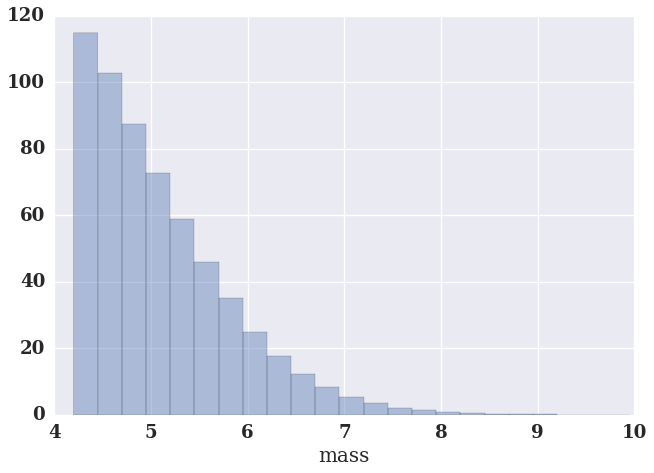

In [12]:
sns.distplot(dimuon_df.mass, hist_kws={'weights': dimuon_df.weight},
             kde=False, bins=[i for i in np.arange(4.2,10.0,0.25)])

In [7]:
pos_to_targ = {1: {'target': 'LH2'},
               2: {'target': 'Empty'},
               3: {'target': 'LD2'},
               4: {'target': 'None'},
               5: {'target': 'Fe'},
               6: {'target': 'C'},
               7: {'target':'W'}}

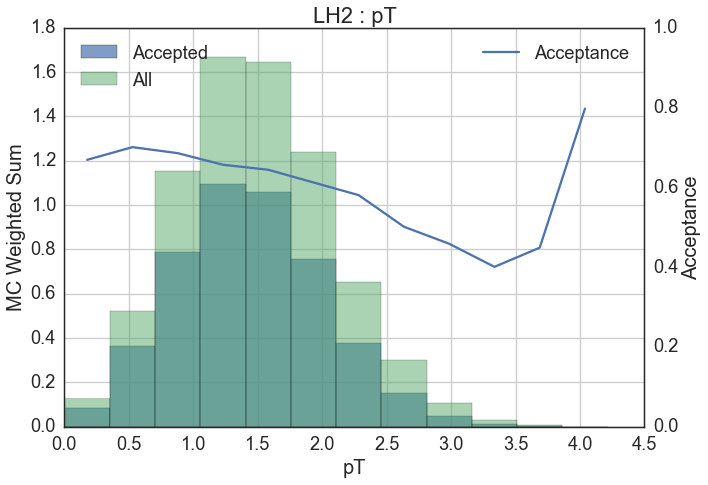

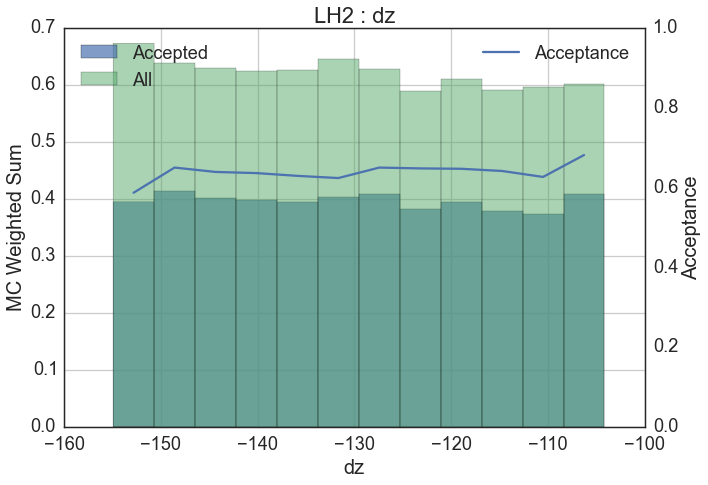

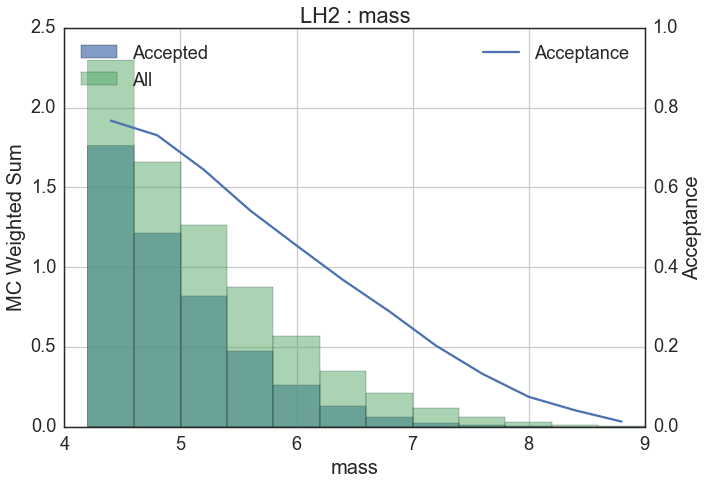

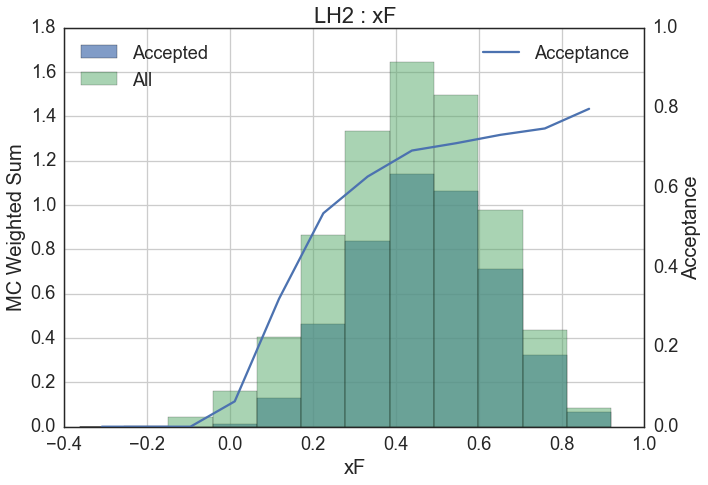

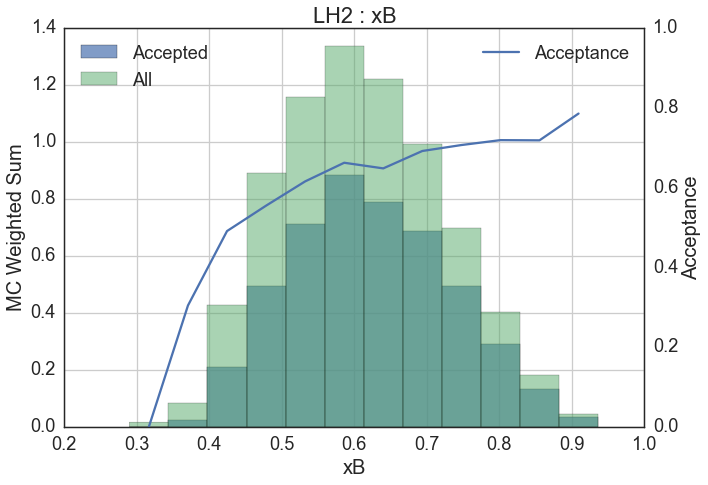

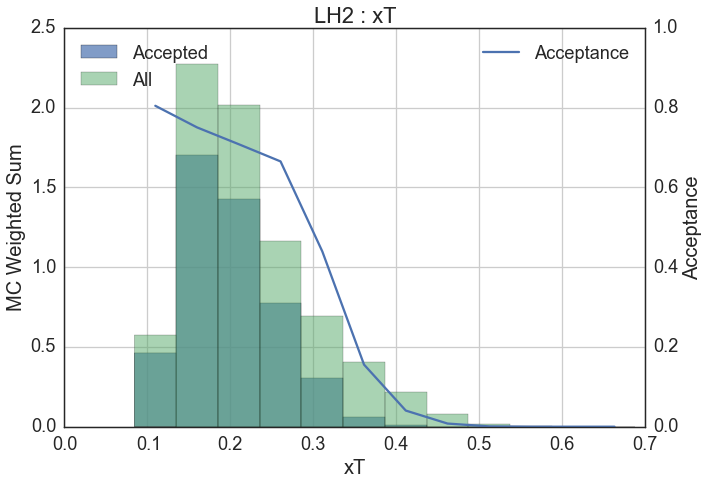

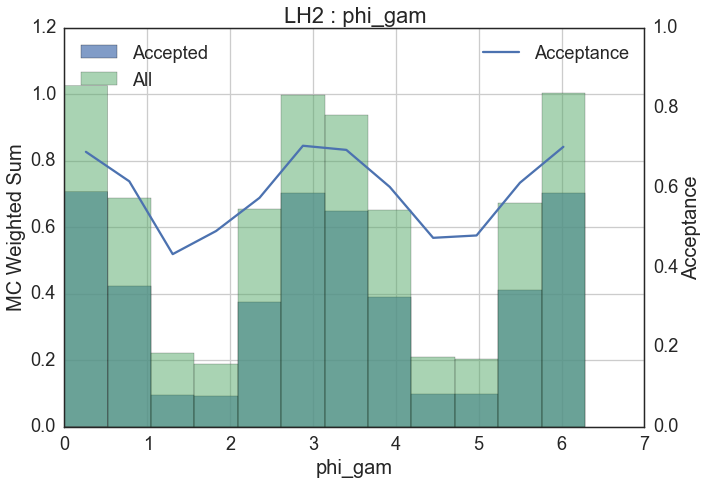

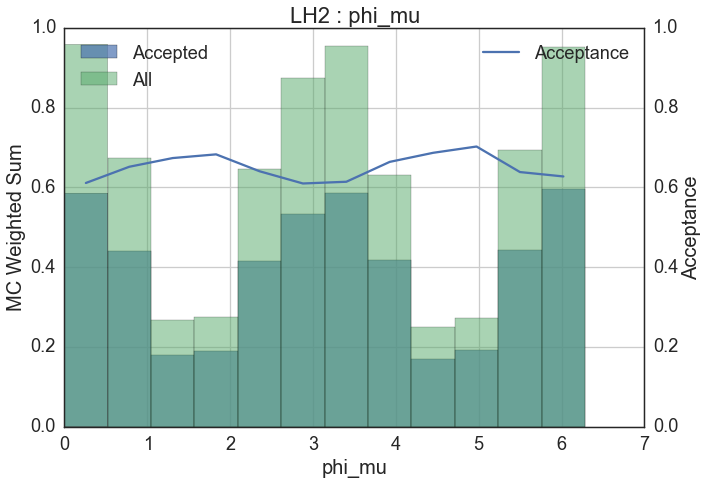

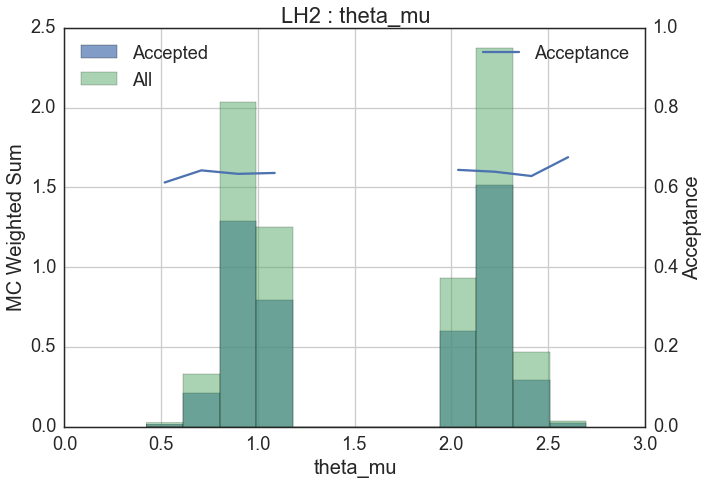

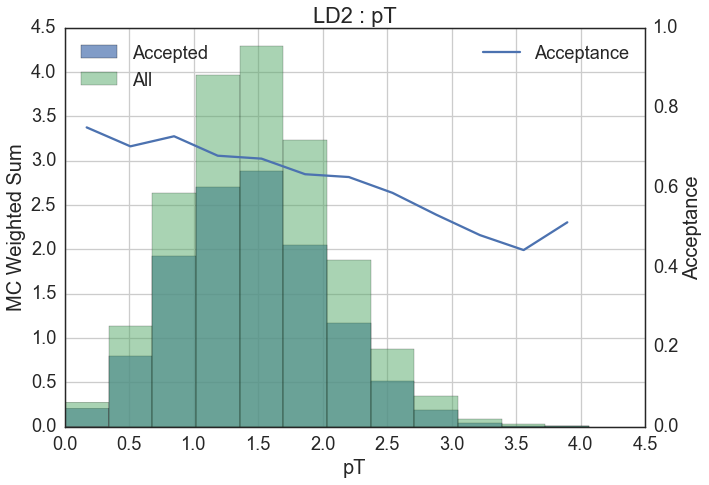

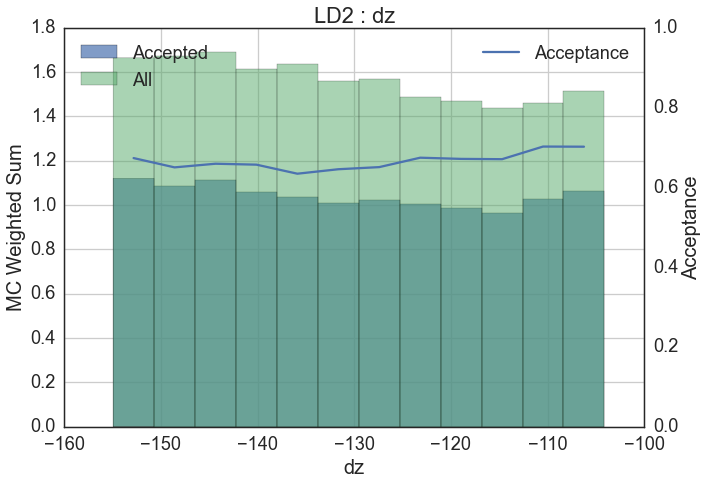

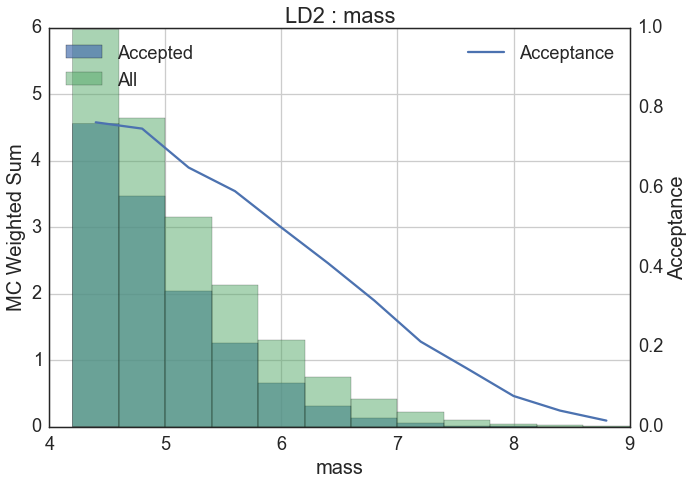

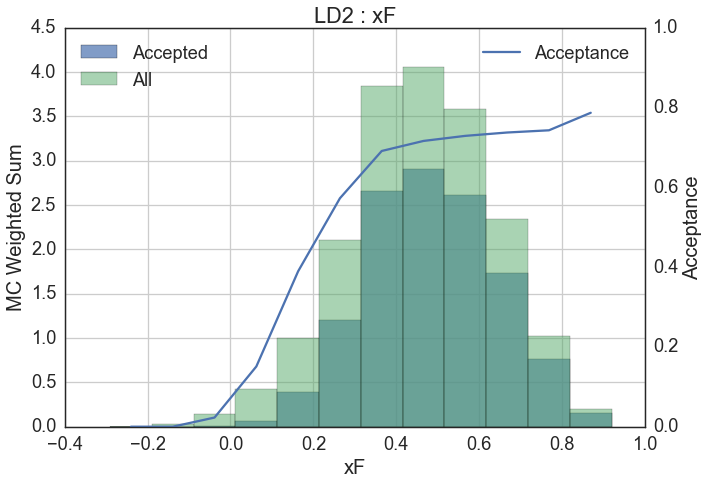

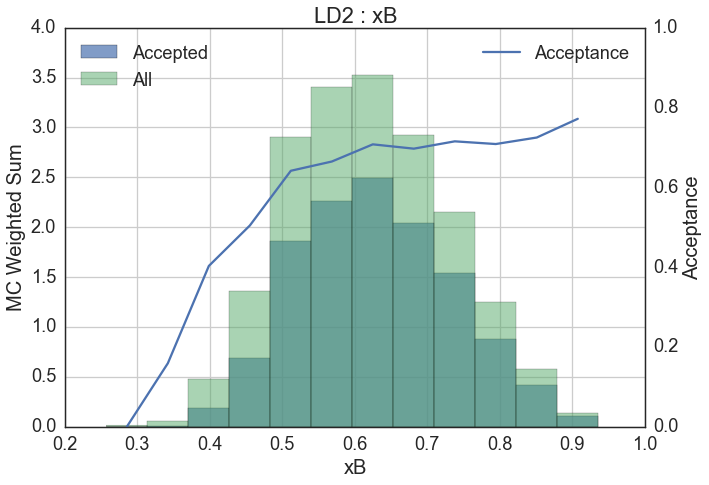

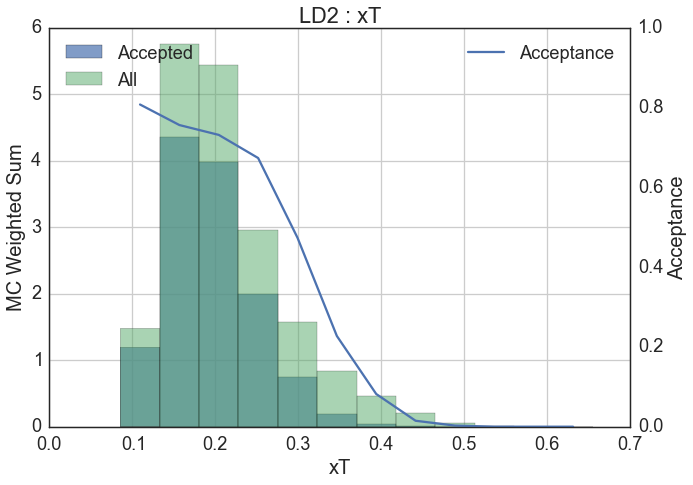

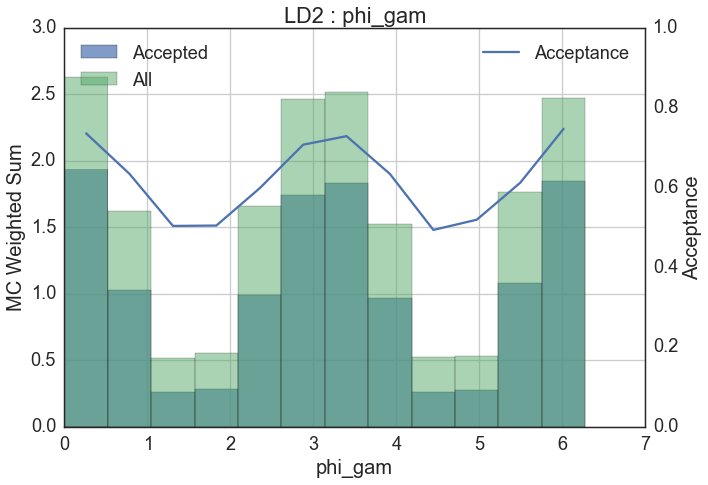

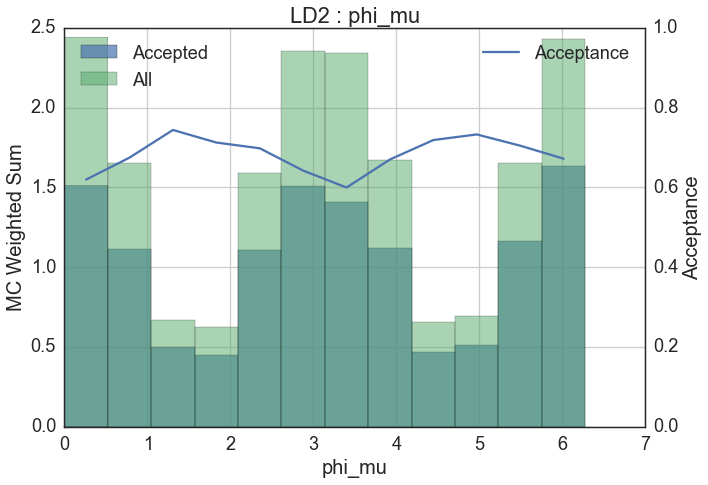

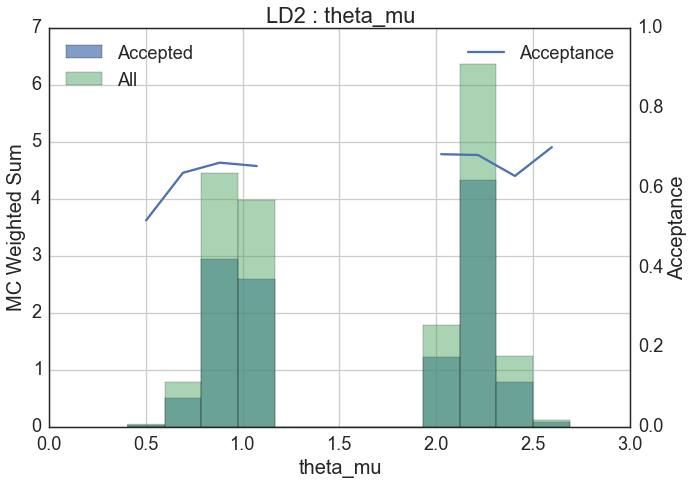

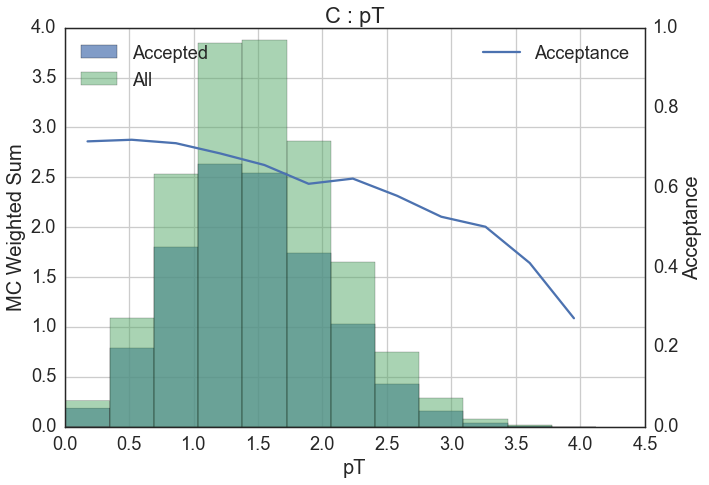

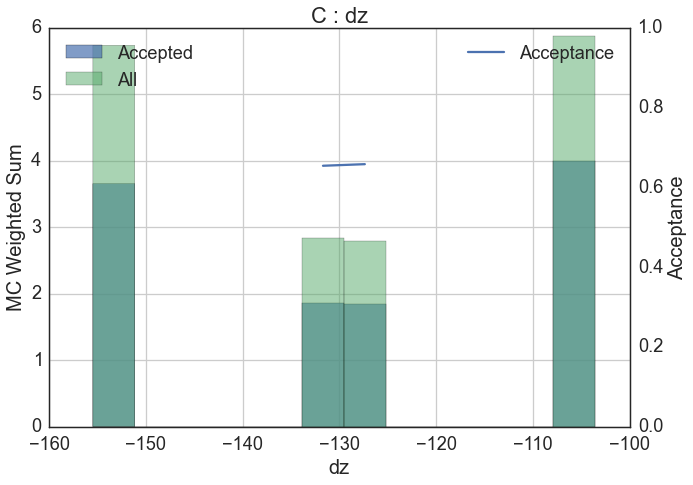

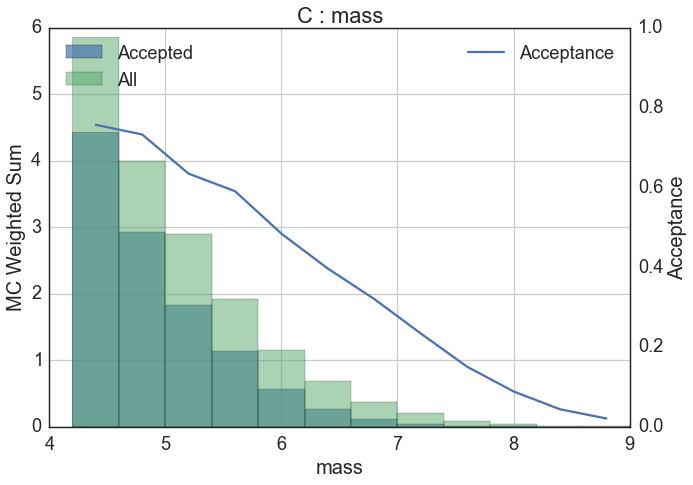

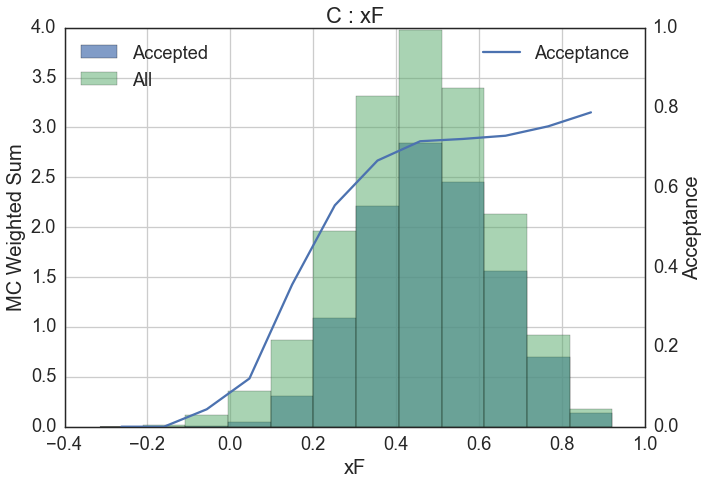

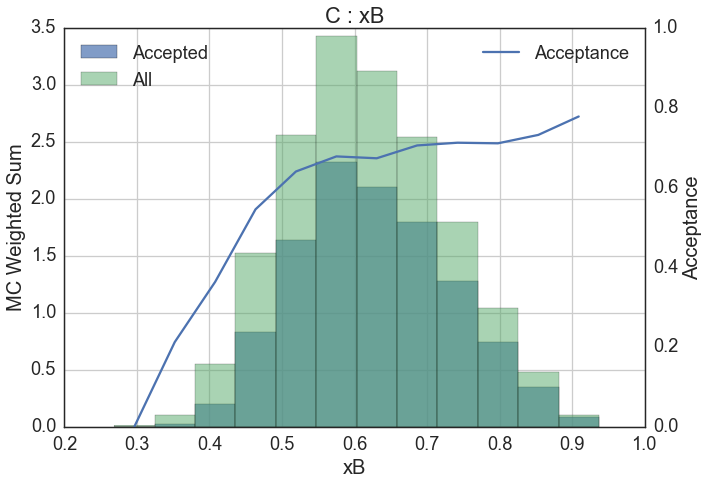

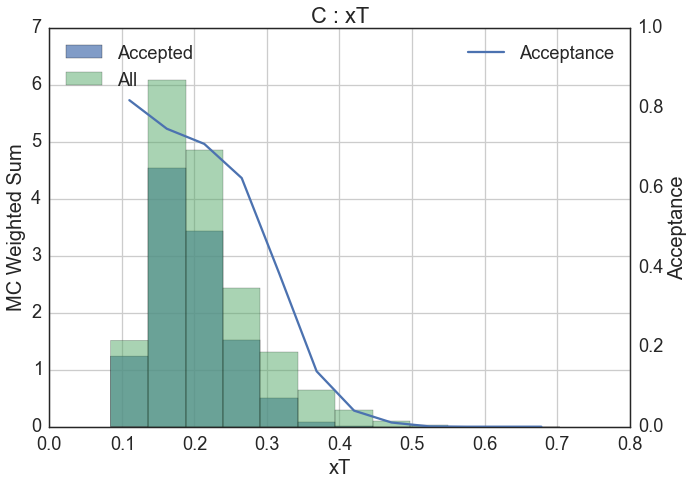

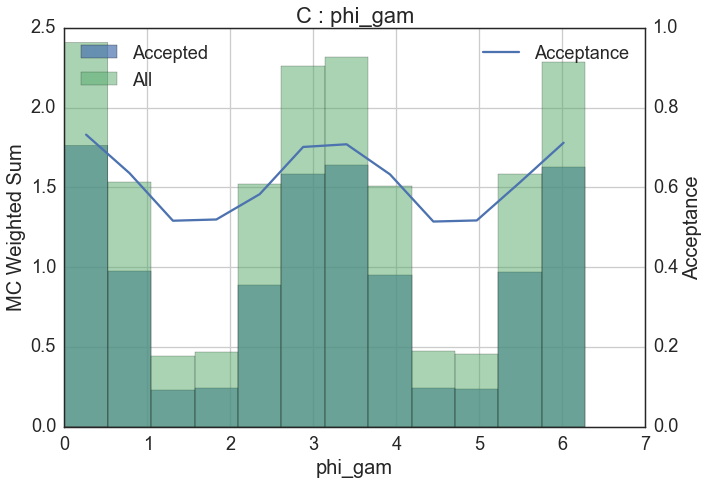

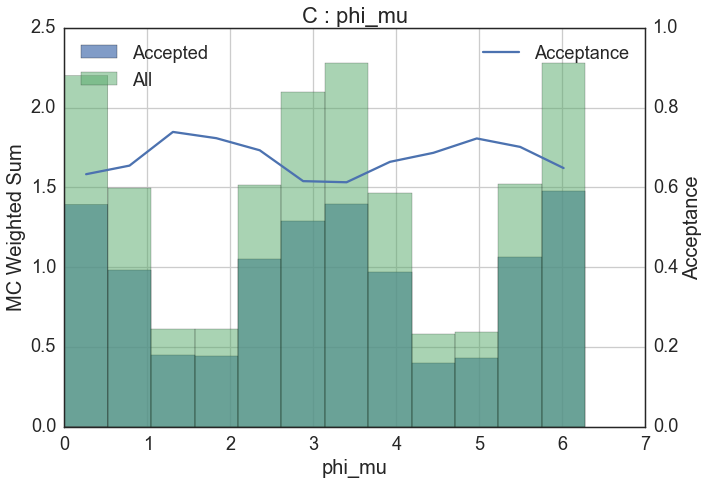

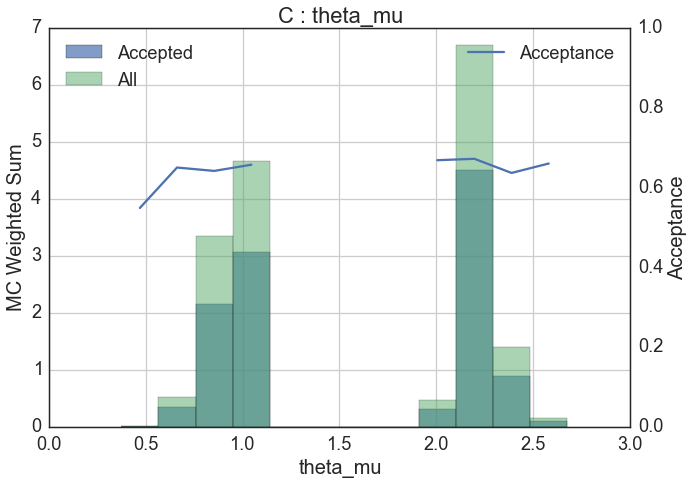

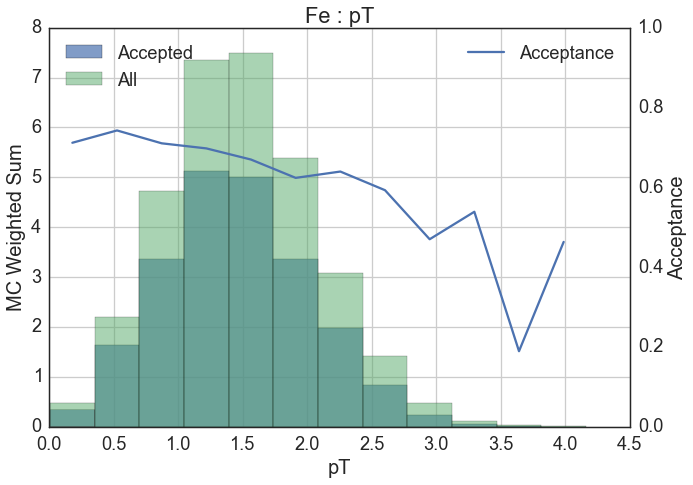

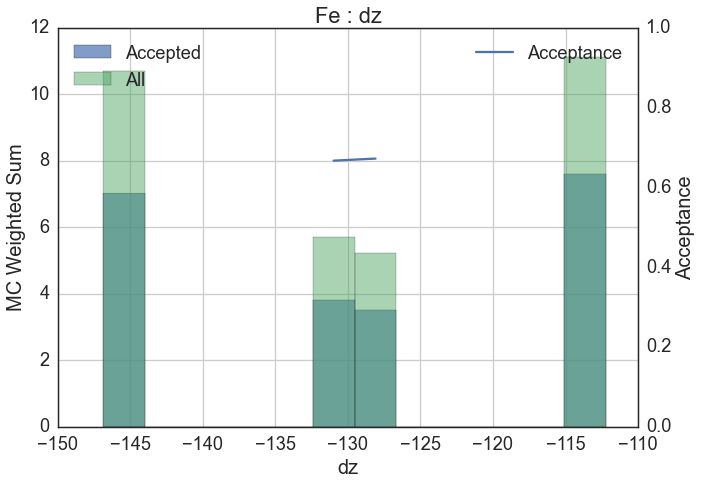

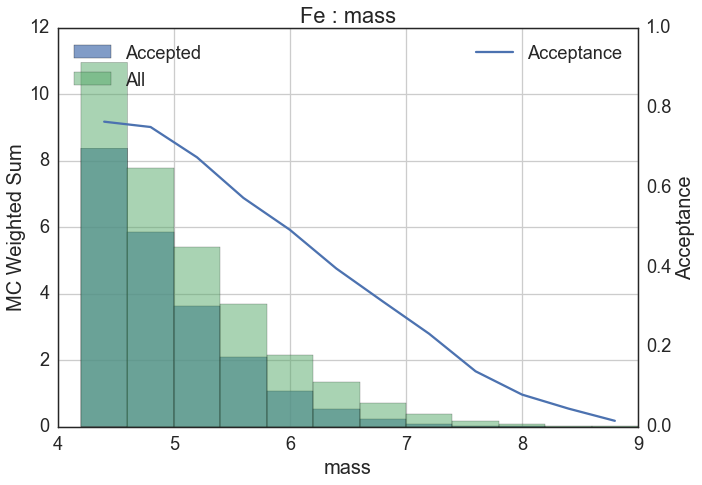

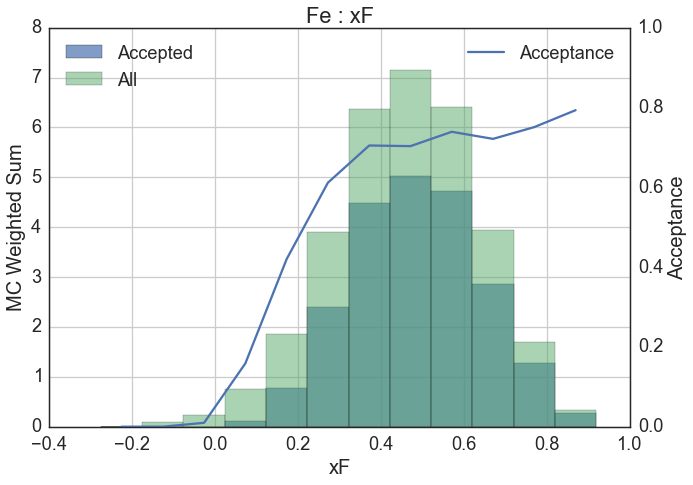

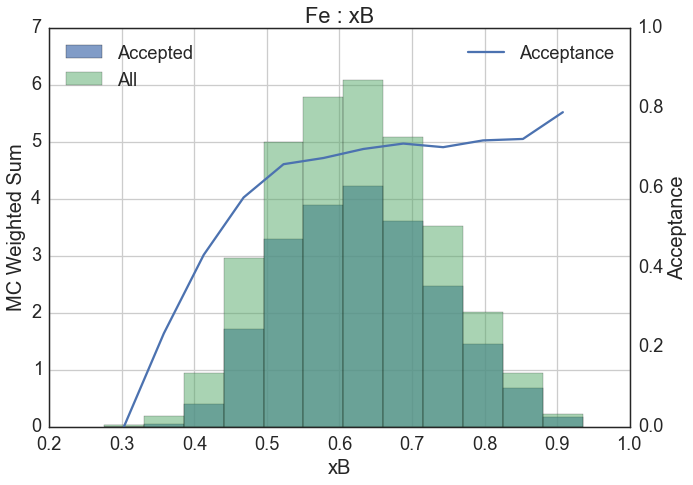

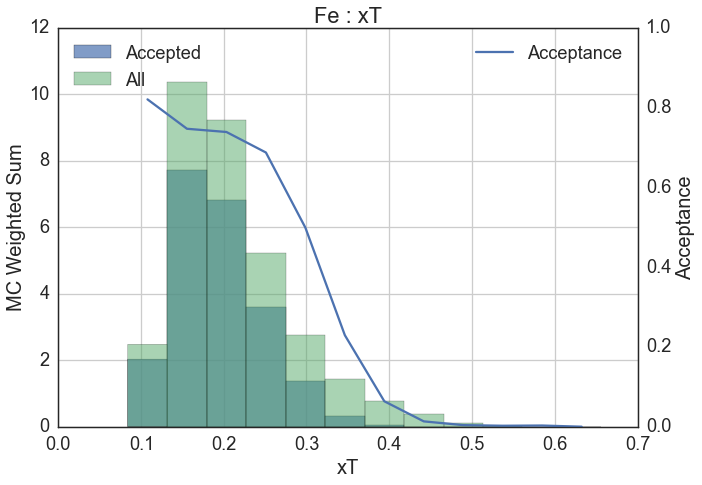

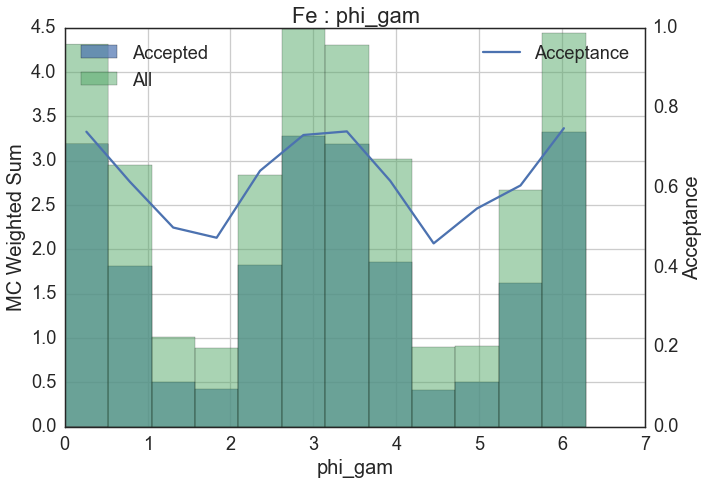

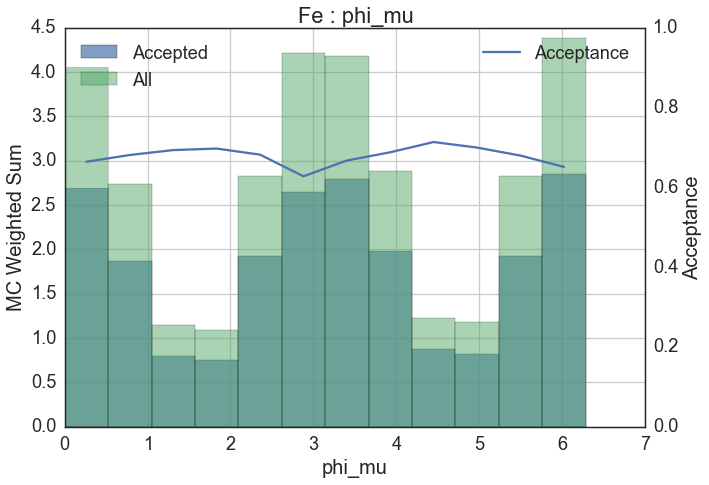

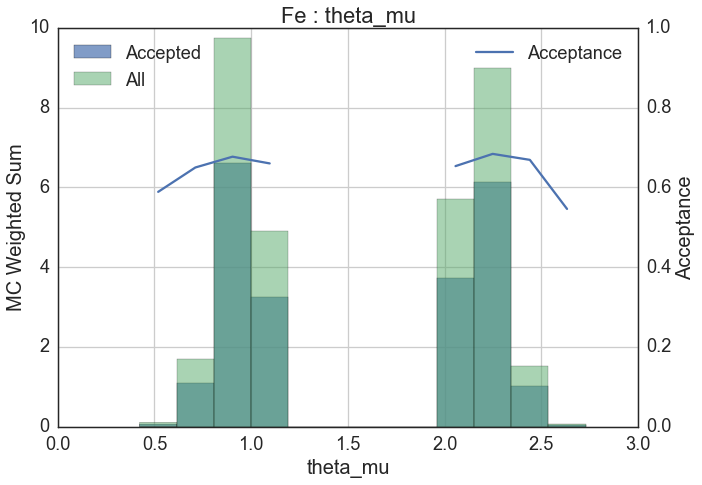

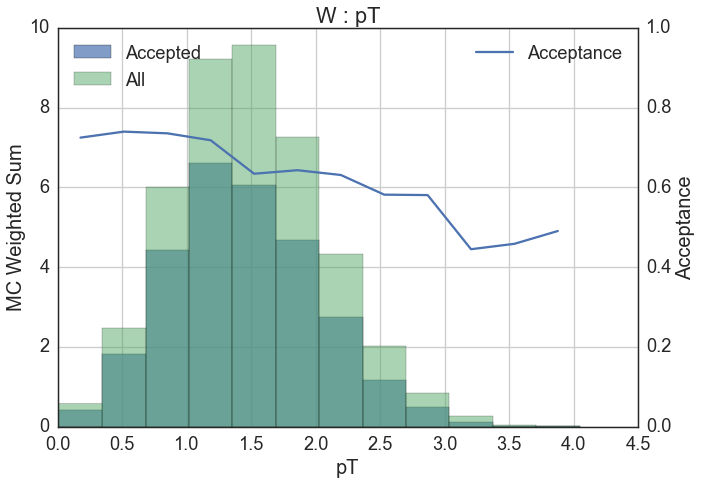

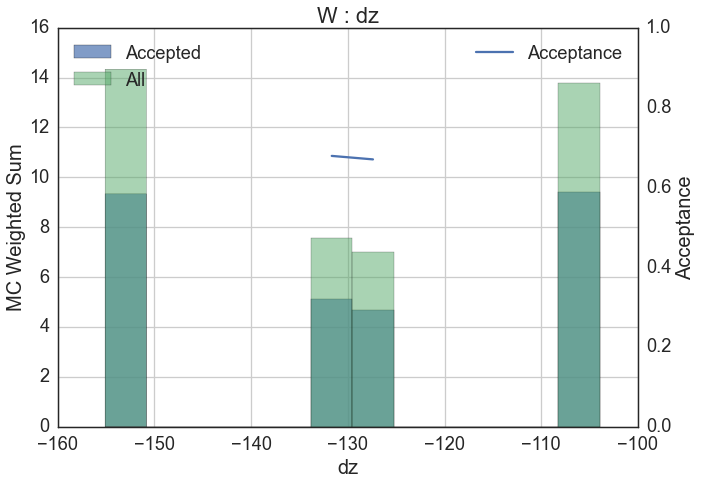

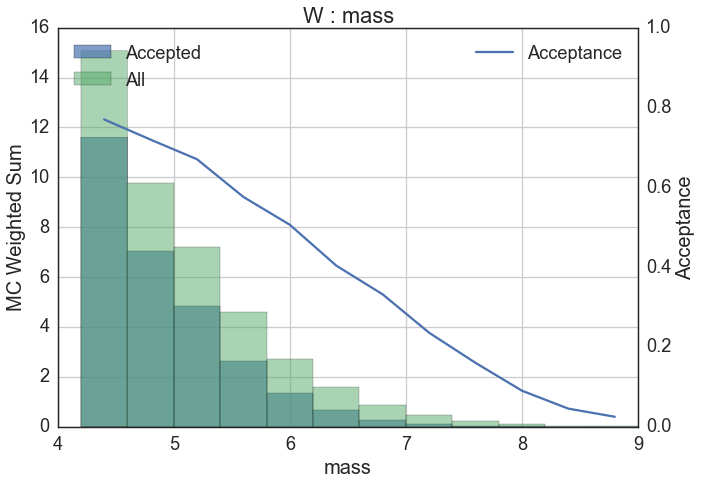

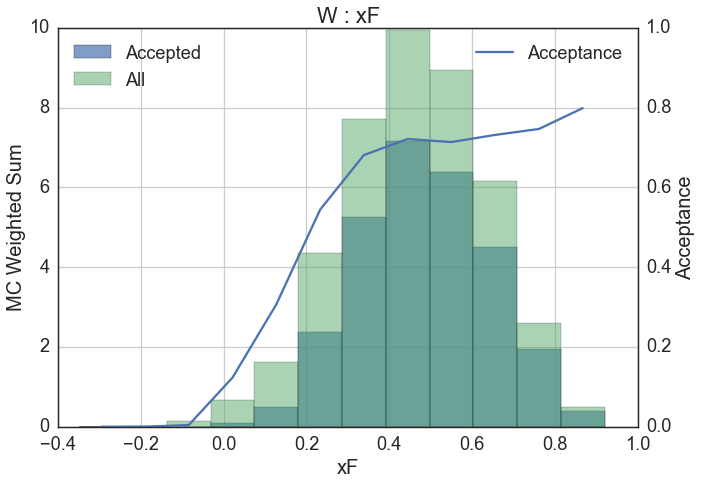

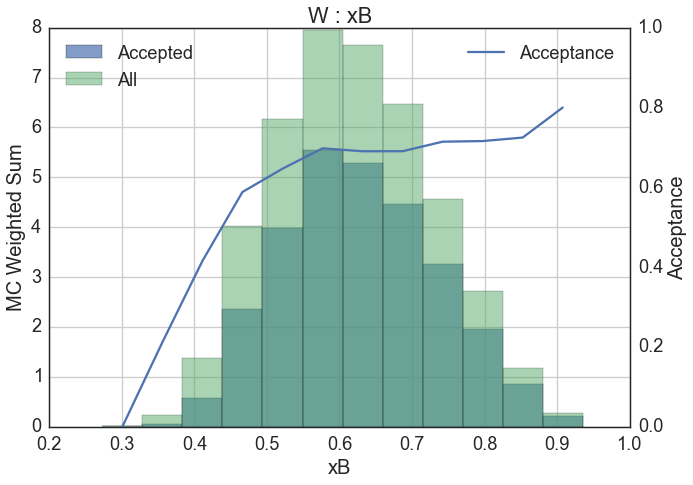

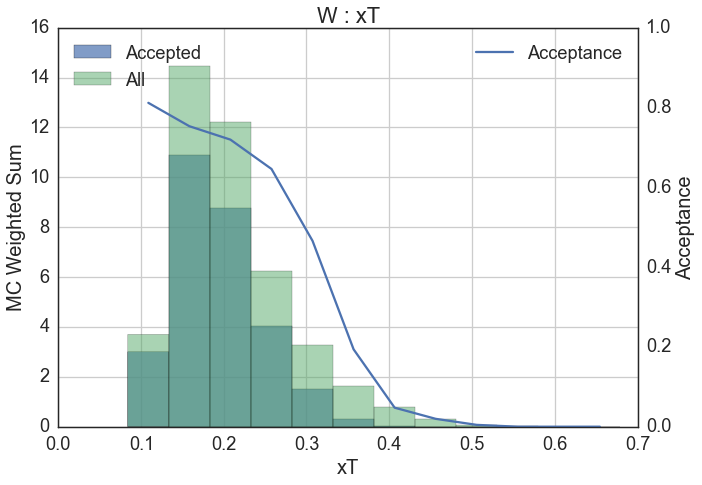

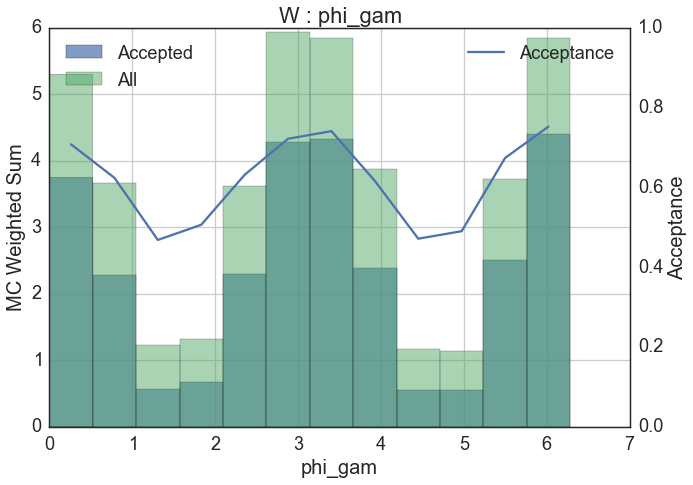

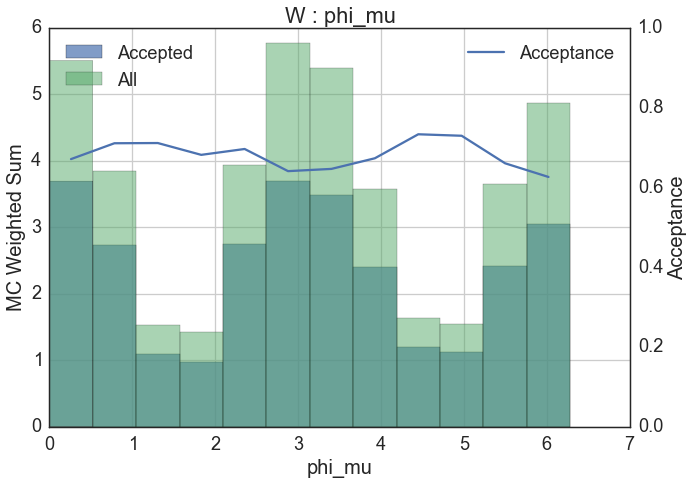

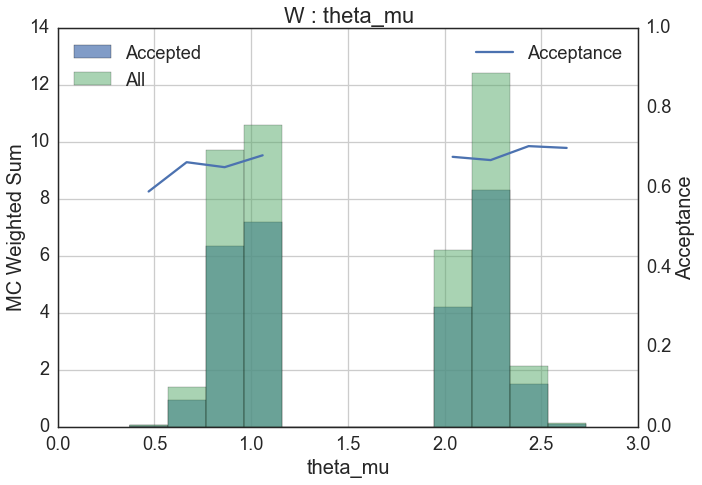

In [8]:
sns.set_style("white")

kinematic_list = ['pT','dz','mass','xF','xB','xT','phi_gam','phi_mu','theta_mu']
targ_list = dimuon_df.targpos.unique()

acceptance_dict = {}

for kinematic in kinematic_list:
    acceptance_dict[kinematic] = {}
    for targ in targ_list:
        acceptance_dict[kinematic][targ] = { 'acceptance': [], 'bin_centers': []}

for targ in targ_list:
    # Slice the data into the target position in question, and Accepted and All
    accepted_df = dimuon_df.query('targpos==@targ and acceptDriftAll==1')
    all_df = dimuon_df.query('targpos==@targ')
    
    # We want to look at the acceptance for each kinematic variable at each target position
    for kinematic in kinematic_list:
        fig, ax1 = plt.subplots()
        
        # Get the values of each histogram, so we're ready to calculate the acceptance
        all_values, bin_edges = np.histogram(all_df[kinematic].values, weights=all_df['weight'], bins=12)
        accepted_values, bin_edges = np.histogram(accepted_df[kinematic].values, 
                                                  bins=bin_edges, weights=accepted_df['weight'])
        # Acceptance = Accepted / All
        acceptance_values = np.divide(accepted_values.astype(float), all_values.astype(float))
        # Calculate the bin centers for plotting usage
        bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
        
        # We'll plot the histograms along with the ratio
        accepted_df[kinematic].hist(bins=bin_edges, weights=accepted_df['weight'].values, 
                                    label="Accepted", alpha=0.7, ax=ax1)
        all_df[kinematic].hist(bins=bin_edges, weights=all_df['weight'].values, 
                               label="All", alpha=0.5, ax=ax1)
        
        # Plot acceptance on the other y-axis
        ax2 = ax1.twinx()
        ax2.plot(bin_centers, acceptance_values, label="Acceptance")
        acceptance_dict[kinematic][targ]['acceptance'] = acceptance_values
        acceptance_dict[kinematic][targ]['bin_centers'] = bin_centers
        
        ax1.set_title(pos_to_targ[targ]['target'] + " : " + kinematic)
        ax1.set_xlabel(kinematic)
        ax1.legend(loc="upper left")
        ax2.legend(loc="upper right")
        ax2.set_ylabel("Acceptance")
        ax1.set_ylabel("MC Weighted Sum")
        ax2.set_ylim([0.0,1.0])
        
        #plt.savefig(pos_to_targ[targ]['target'] + '-' + kinematic + '.png')
        plt.show()     
    del accepted_df
    del all_df

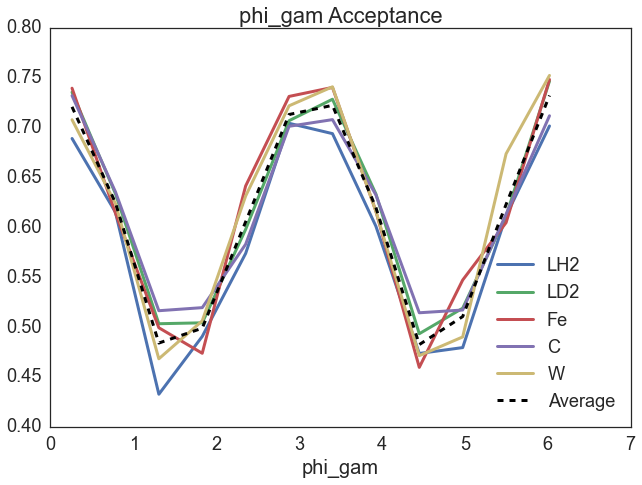

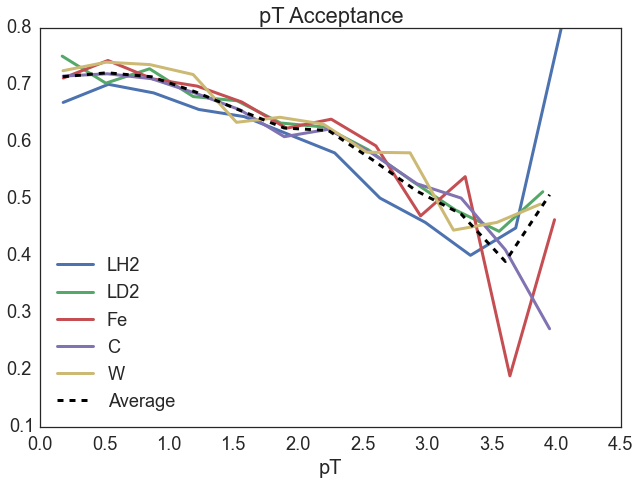

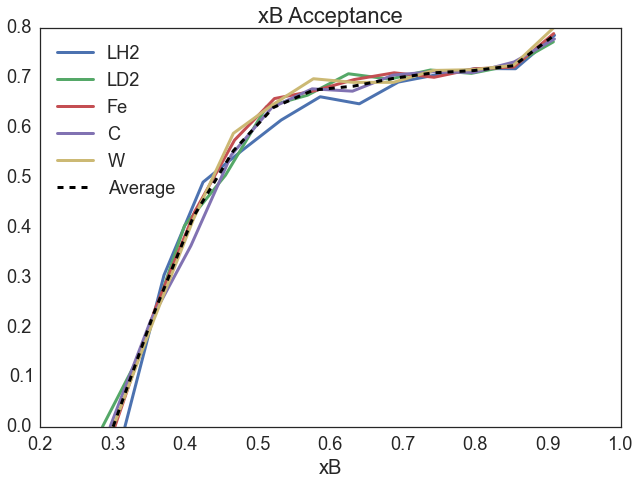

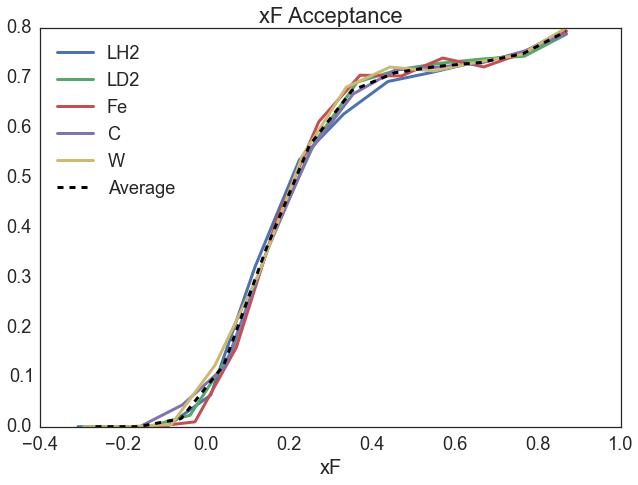

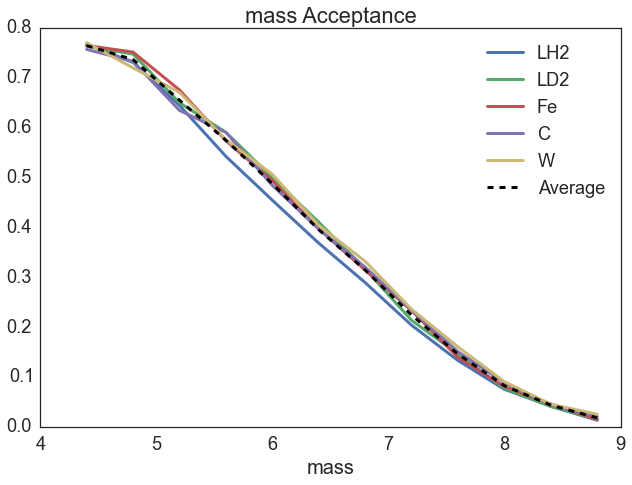

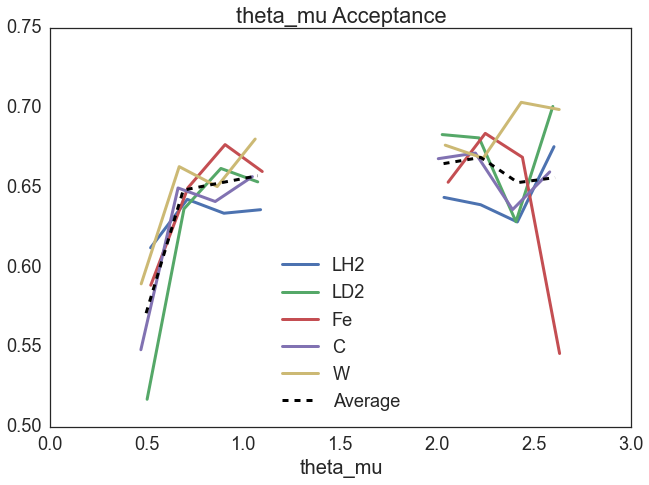

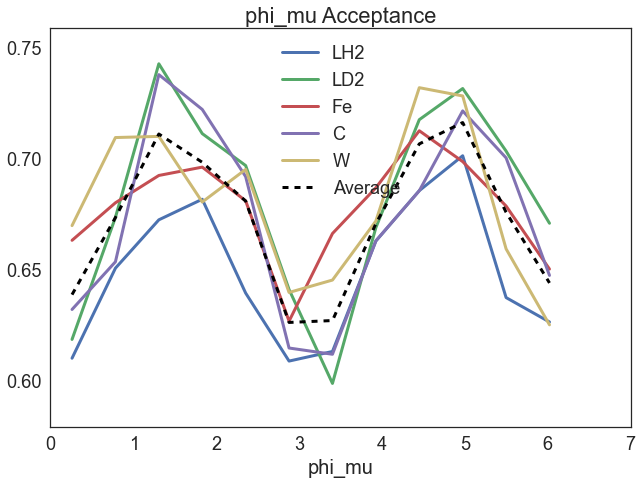

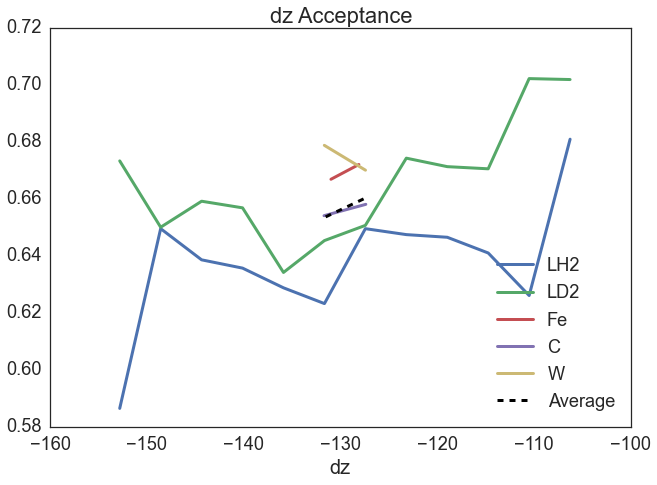

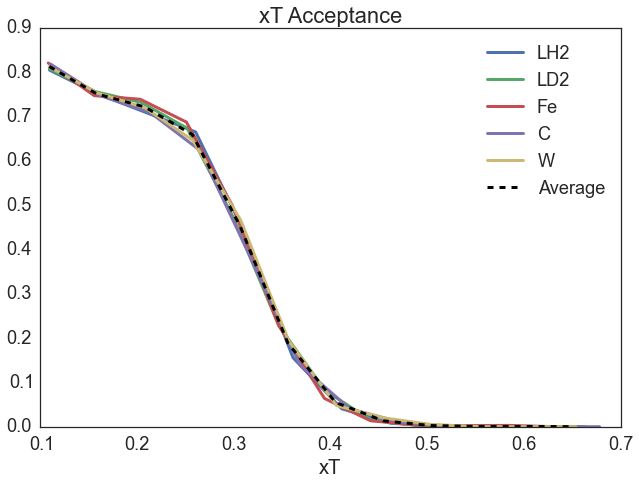

In [9]:
sns.set_style("white")
for kinematic in acceptance_dict:
    fig = plt.figure()
    avg_acceptance = np.zeros(12)
    avg_bin_centers = np.zeros(12)
    
    for targ in acceptance_dict[kinematic]:
        
        plt.plot(acceptance_dict[kinematic][targ]['bin_centers'], acceptance_dict[kinematic][targ]['acceptance'],
                label=pos_to_targ[targ]['target'], lw=3)
        np.add(avg_acceptance,acceptance_dict[kinematic][targ]['acceptance'], avg_acceptance)
        np.add(avg_bin_centers,acceptance_dict[kinematic][targ]['bin_centers'], avg_bin_centers)
        
    avg_acceptance = np.divide(avg_acceptance.astype(float),(float)(len(acceptance_dict[kinematic])))
    avg_bin_centers = np.divide(avg_bin_centers.astype(float),(float)(len(acceptance_dict[kinematic])))
    
    plt.plot(avg_bin_centers, avg_acceptance,'k--', label="Average", lw=3)
        
    plt.title(kinematic + " Acceptance")
    plt.xlabel(kinematic)
    plt.legend(loc="best")
    plt.savefig(kinematic + '-acceptance.png')
    plt.show()     

# Get A/D Acceptance Ratios
* If we assume the following to be true:
$$ None < A, Empty < D$$
$$\frac{A-None}{D-Empty} \approx \frac{A}{D}$$
* Then acceptance corrections for ratio measurements can be approximated by looking to ratios of acceptances

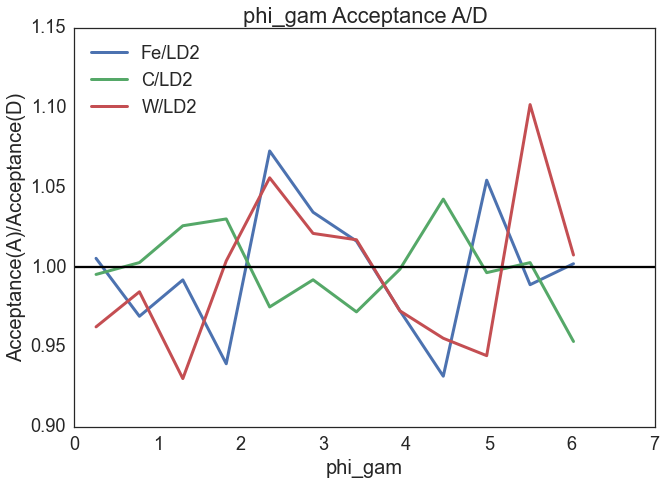

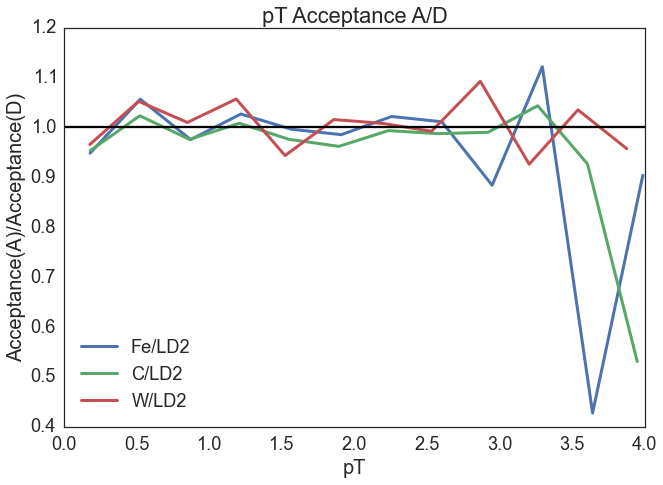

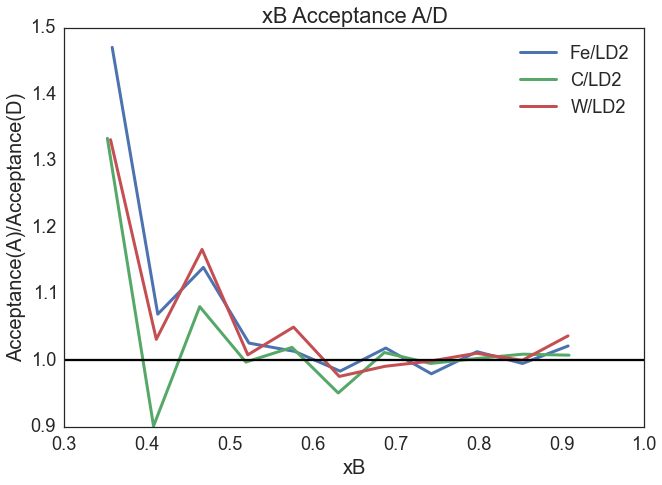

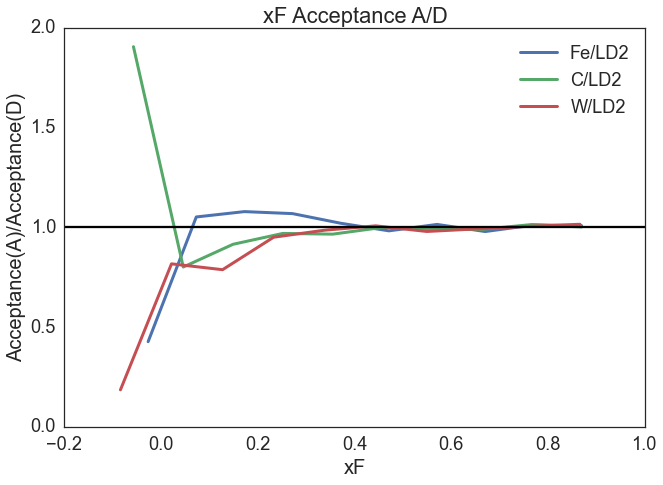

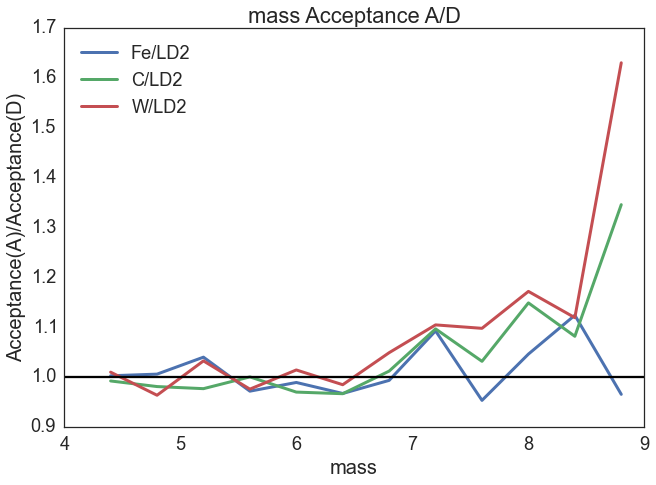

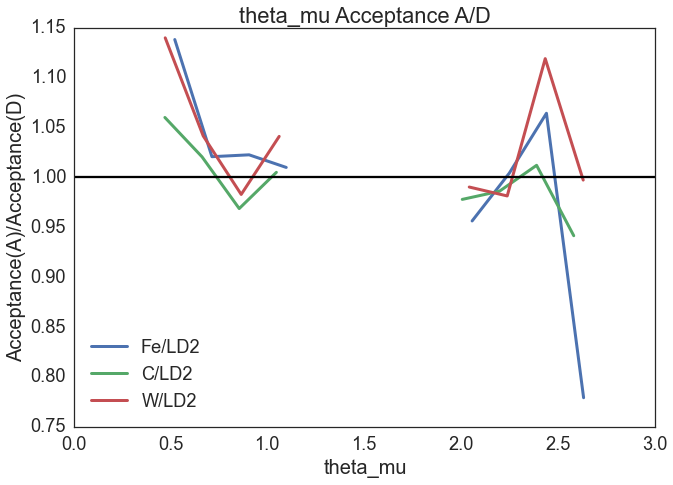

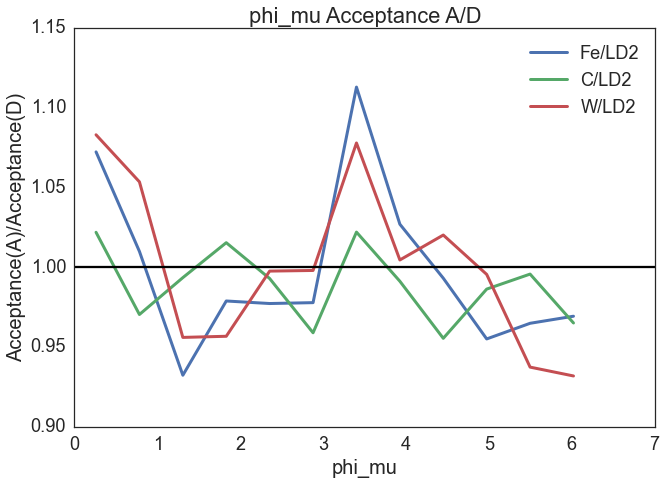

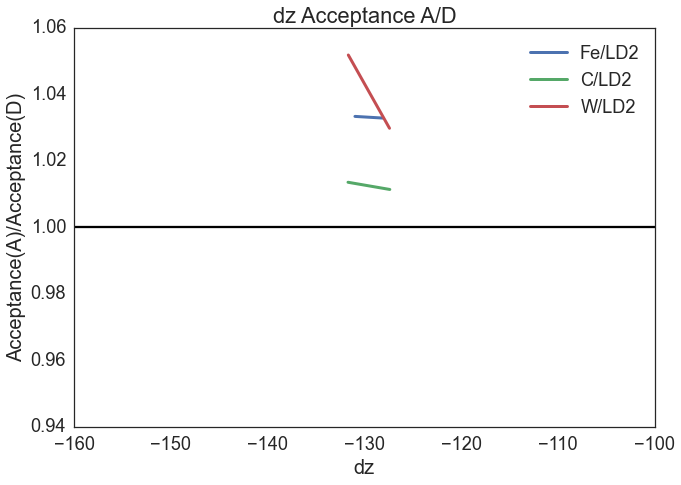

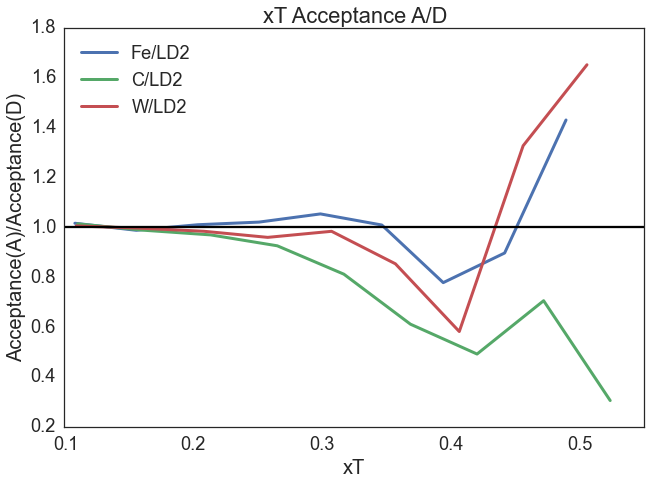

In [11]:
sns.set_style("white")
for kinematic in acceptance_dict:
    fig = plt.figure()
    
    for targ in [5,6,7]:
        
        plt.plot(acceptance_dict[kinematic][targ]['bin_centers'], 
                 acceptance_dict[kinematic][targ]['acceptance'] / acceptance_dict[kinematic][3]['acceptance'],
                 label=pos_to_targ[targ]['target'] + '/LD2', lw=3)
        
    plt.axhline(y=1, color='k')
    plt.title(kinematic + " Acceptance A/D")
    plt.xlabel(kinematic)
    plt.ylabel("Acceptance(A)/Acceptance(D)")
    plt.legend(loc="best")
    #plt.savefig(kinematic + '-acceptance-ratio.png')
    plt.show()     

# Solid Target Slices Study

In [10]:
dimuon_df['dz'] = (np.ceil(dimuon_df['dz']/15.0)*15)

In [11]:
print 'C', dimuon_df.query("target=='C'")['dz'].unique()
print 'Fe', dimuon_df.query("target=='Fe'")['dz'].unique()
print 'W', dimuon_df.query("target=='W'")['dz'].unique()

C [ -90. -150. -120.]
Fe [-135. -120. -105.]
W [-150. -120.  -90.]


In [12]:
emc_t1_df, means_t1_df = mc_emc_analysis(dimuon_df.query("((target=='C' or target=='W') and dz==-150.0) or (target=='Fe' and dz==-135.0) or target=='LD2' or target=='LH2'"),5, x_range=(0.0,0.5))
emc_t2_df, means_t2_df = mc_emc_analysis(dimuon_df.query("((target=='C' or target=='W' or target=='Fe') and dz==-120.0) or target=='LD2' or target=='LH2'"),5, x_range=(0.0,0.5))
emc_t3_df, means_t3_df = mc_emc_analysis(dimuon_df.query("((target=='C' or target=='W') and dz==-90.0) or (target=='Fe' and dz==-105.0) or target=='LD2' or target=='LH2'"),5, x_range=(0.0,0.5))

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5]
[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5]
[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5]


/usr/lib/python2.7/dist-packages/pandas/core/categorical.py:22: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return f(np.asarray(other))


In [94]:
emc_t1_df

,xT,D/H,C/D,Fe/D,Fe/D(iso),W/D,W/D(iso)
xT,,,,,,,
"(0, 0.1]",0.0954985,1.10+/-0.11,0.30+/-0.05,0.29+/-0.04,0.29+/-0.05,0.37+/-0.06,0.36+/-0.06
"(0.1, 0.2]",0.1558466,1.181+/-0.029,0.343+/-0.012,0.342+/-0.012,0.339+/-0.012,0.341+/-0.012,0.331+/-0.012
"(0.2, 0.3]",0.2499266,1.062+/-0.028,0.344+/-0.013,0.328+/-0.012,0.327+/-0.012,0.336+/-0.013,0.332+/-0.013
"(0.3, 0.4]",0.3499033,0.818+/-0.025,0.353+/-0.015,0.320+/-0.013,0.325+/-0.014,0.324+/-0.014,0.339+/-0.015
"(0.4, 0.5]",0.4395758,0.743+/-0.030,0.415+/-0.020,0.383+/-0.022,0.393+/-0.023,0.388+/-0.019,0.418+/-0.023


In [14]:
bin_centers = emc_t1_df['xT'].values

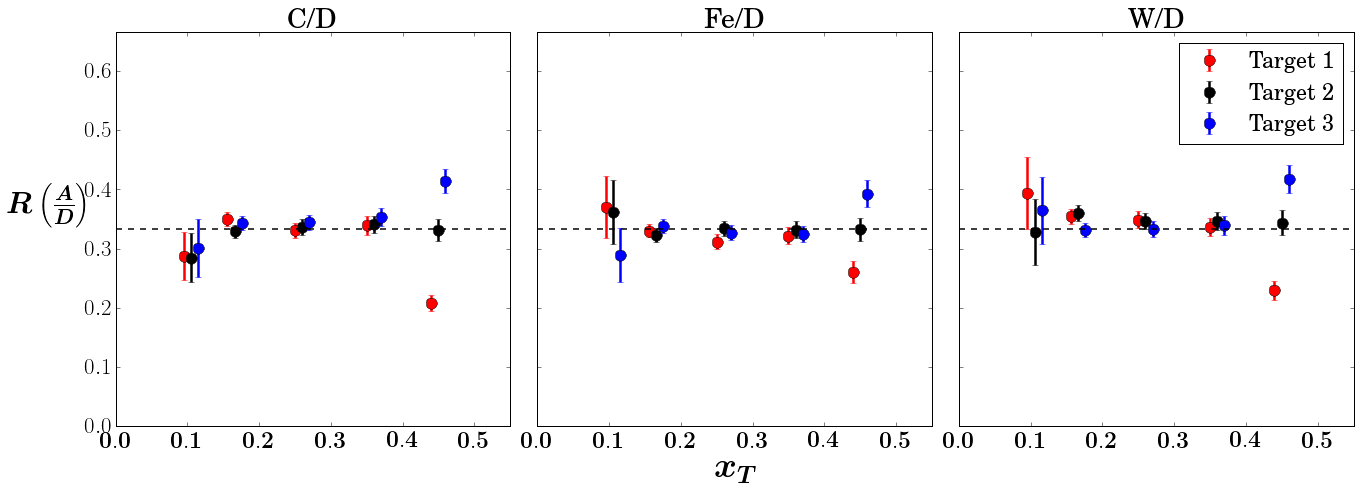

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(19,7))

bin_centers_t1 = emc_t1_df['xT'].values
bin_centers_t2 = emc_t2_df['xT'].values
bin_centers_t3 = emc_t3_df['xT'].values

ax1.set_title('C/D', fontsize=28)
ax1.errorbar(bin_centers_t1, unp.nominal_values(emc_t1_df['C/D'].values),
             yerr=unp.std_devs(emc_t1_df['C/D'].values),
             fmt='o', ms=11, elinewidth=2.5, color='red', label='Target 1')
ax1.errorbar(bin_centers_t2+0.01, unp.nominal_values(emc_t2_df['C/D'].values),
             yerr=unp.std_devs(emc_t2_df['C/D'].values),
             fmt='o', ms=11, elinewidth=2.5, color='black', label='Target 2')
ax1.errorbar(bin_centers_t3+0.02, unp.nominal_values(emc_t3_df['C/D'].values),
             yerr=unp.std_devs(emc_t3_df['C/D'].values),
             fmt='o', ms=11, elinewidth=2.5, color='blue', label='Target 3')
ax1.axhline(y=0.333, c='black', ls='--', linewidth=1.5)
ax1.set_ylabel(r'$\boldsymbol{R \left(\frac{A}{D}\right)}$', fontsize=30, rotation=0, labelpad=35)
plt.setp(ax1.get_xticklabels(), fontsize=23)
plt.setp(ax1.get_yticklabels(), fontsize=23)

ax2.set_title('Fe/D', fontsize=28)
ax2.errorbar(bin_centers_t1, unp.nominal_values(emc_t1_df['Fe/D(iso)'].values),
             yerr=unp.std_devs(emc_t1_df['Fe/D(iso)'].values),
             fmt='o', ms=11, elinewidth=2.5, color='red', label='Target 1')
ax2.errorbar(bin_centers_t2+0.01, unp.nominal_values(emc_t2_df['Fe/D(iso)'].values),
             yerr=unp.std_devs(emc_t2_df['Fe/D(iso)'].values),
             fmt='o', ms=11, elinewidth=2.5, color='black', label='Target 1')
ax2.errorbar(bin_centers_t3+0.02, unp.nominal_values(emc_t3_df['Fe/D(iso)'].values),
             yerr=unp.std_devs(emc_t3_df['Fe/D(iso)'].values),
             fmt='o', ms=11, elinewidth=2.5, color='blue', label='Target 3')
ax2.set_xlabel(r'$\boldsymbol{x_T}$', fontsize=35)
ax2.axhline(y=0.333, c='black', ls='--', linewidth=1.5)
plt.setp(ax2.get_xticklabels(), fontsize=23)

ax3.set_title('W/D', fontsize=28)
ax3.errorbar(bin_centers_t1, unp.nominal_values(emc_t1_df['W/D(iso)'].values),
             yerr=unp.std_devs(emc_t1_df['W/D(iso)'].values), 
             fmt='o', ms=11, elinewidth=2.5, color='red', label='Target 1')
ax3.errorbar(bin_centers_t2+0.01, unp.nominal_values(emc_t2_df['W/D(iso)'].values),
             yerr=unp.std_devs(emc_t2_df['W/D(iso)'].values), 
             fmt='o', ms=11, elinewidth=2.5, color='black', label='Target 2')
ax3.errorbar(bin_centers_t3+0.02, unp.nominal_values(emc_t3_df['W/D(iso)'].values),
             yerr=unp.std_devs(emc_t3_df['W/D(iso)'].values), 
             fmt='o', ms=11, elinewidth=2.5, color='blue', label='Target 3')
ax3.axhline(y=0.333, c='black', ls='--', linewidth=1.5)
ax3.legend(loc='best', fontsize=22, numpoints=1)
plt.setp(ax3.get_xticklabels(), fontsize=23)

xtick_locs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
#ytick_locs = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plt.xticks(xtick_locs, [r"$\mathbf{%.1f}$" % x for x in xtick_locs]) 
#plt.yticks(ytick_locs, [r"$\mathbf{%.1f}$" % x for x in ytick_locs]) 

ax3.axis((0, 0.55, 0.0, 0.666))

plt.tight_layout()
plt.setp([a.get_yticklabels() for a in f.axes[1:]], visible=False)
plt.setp([a.get_xticklines() for a in f.axes[:]], lw=20)
plt.show()